In [1]:
import sqlite3
import re
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from lsst.afw.table import BaseCatalog
import data_process_utils as dpu
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from astropy.visualization import ZScaleInterval
import lsst.afw.image as afwImage
from lsst.daf.persistence import Butler
interval = ZScaleInterval()

In [2]:
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']

#### Flag Analysis

In [3]:
"""
def get_confm(flux_df, art_df, flag):
    tp = (flux_df[flag]  == 0).sum()
    fp = (art_df[flag]  == 0).sum()
    tn = (art_df[flag]  == 1).sum()
    fn = (flux_df[flag]  == 1).sum()
    # rejection rate
    rr = fn / len(flux_df)
    return np.array([tp, fp, tn, fn, rr])
""";

def get_confm(flux_df, art_df, flag):
    tp = (flux_df[flag]  == 0).sum()
    fp = (art_df[flag]  == 0).sum()
    tn = (art_df[flag]  == 1).sum()
    fn = (flux_df[flag]  == 1).sum()
    # rejection rate
    # rr = fn / len(flux_df)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return np.array([precision, recall, f1])

def get_confusion_matrix(flux_df, art_df, flag_cols):
    confusion_matrix = np.array([0, 0, 0])
    flag_list = []
    for flag in flag_cols:
        row = get_confm(flux_df, art_df, flag)
        """
        if row[0] < len(flux_df) or row[2] < len(fp_df):
            confusion_matrix = np.vstack((confusion_matrix, row))
            flag_list.append(flag)
        """
        confusion_matrix = np.vstack((confusion_matrix, row))
        flag_list.append(flag)
    confusion_matrix = confusion_matrix[1:, :]  
    return confusion_matrix, flag_list

In [150]:
config = 'al_default'
db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
flux = pd.read_sql_query("SELECT * FROM fake_src WHERE host_mag = '20_21' and fake_mag = 20", conn)
flux_det = flux.loc[flux.matched_status.astype(bool)]

db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)

In [26]:
t = BaseCatalog.readFits('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/schema/deepDiff_diaSrc.fits')
schema = t.schema

In [27]:
len(art), len(flux), len(flux_det)

(1862, 1184, 1184)

In [28]:
FLAG_LIST = [
    'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_suspectCenter',
    'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge','base_PixelFlags_flag_bad',
    'ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted',
    'base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag'
]
confusion_matrix, flag_list = get_confusion_matrix(flux_det, art, FLAG_LIST)

FULL_FLAGS = []
for i in flux_det.columns:
    if re.search('flag', i):
        FULL_FLAGS.append(i)
confusion_matrix_full, flag_list_full = get_confusion_matrix(flux_det, art, FULL_FLAGS)

In [29]:
def count_neg(df, flag_list):
    tof = np.zeros(len(df))
    for flag in flag_list:
        state = (df[flag] == 1).to_numpy()
        tof = np.logical_or(tof, state)
    return tof.sum()

def count_pos(df, flag_list):
    tof = np.ones(len(df))
    for flag in flag_list:
        state = (df[flag] == 0).to_numpy()
        tof = np.logical_and(tof, state)
    return tof.sum()

In [30]:
union_tp = count_pos(flux_det, FLAG_LIST)
union_fp = count_pos(art, FLAG_LIST)
union_tn = count_neg(art, FLAG_LIST)
union_fn = count_neg(flux_det, FLAG_LIST)
unoin_rr = union_fn / len(flux_det)
union_precision = union_tp / (union_tp + union_fp)
union_recall = union_tp / (union_tp + union_fn)
union_f1 = 2 * union_precision * union_recall / (union_precision + union_recall)

In [31]:
union_tp, union_fp, union_tn, union_fn, union_precision, union_recall, union_f1

(1183,
 146,
 1716,
 1,
 0.8901429646350639,
 0.9991554054054054,
 0.9415041782729805)

In [32]:
union_tp + union_fn, len(flux_det)

(1184, 1184)

In [33]:
union_fp + union_tn, len(art)

(1862, 1862)

In [34]:
# selected flags
with open('paper_flag_table.txt', "w+") as file:
    file.write("\\begin{deluxetable*}{llrrr}\n")
    file.write("\\tablecaption{Confusion Matrces of Selected Flags "
               "\\label{tab:flag_selected}}\n")
    file.write("\\tablewidth{0pt}\n")
    file.write("\\tabletypesize{\scriptsize}\n")
    file.write("\\tablehead{\n")
    file.write("\\colhead{Flag} & \\colhead{Description} & \\colhead{Precision} & \\colhead{Recall} & \\colhead{$F_1$}}\n")
    file.write("\\startdata\n")
    for i, flag in enumerate(FLAG_LIST):
        flag_name = flag.replace('_', '\\_')
        dscp = schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()
        dscp = dscp.replace('_', '\\_')
        file.write(f"{flag_name} & {dscp} & {confusion_matrix[i, 0]:.4f} & {confusion_matrix[i, 1]:.4f} & {confusion_matrix[i, 2]:.4f}\\\\\n")
    file.write(f"Union of Selected Flags & Apply all of above flags for source selection & "
               f"{union_precision:.4f} & {union_recall:.4f} & {union_f1:.4f} \\\\\n")
    file.write("\\enddata\n")
    file.write("\\tablecomments{For a specific flag, precision is the fraction of detected "
               "synthetic sources which do not have this flag set to True over the number of "
               "all detections. Recall is the number of detected synthetic sources which do not "
               "have this flag set to True over the number of all injected synthetic sources. $F_1$ "
               "is their harmonic mean. A flag with high precision and recall is helpful for filtering "
               "out artifacts.The last row shows the results of applying all of selected flags.}\n")
    file.write("\\end{deluxetable*}\n")

In [35]:
"""
# selected flags
with open('paper_flag_table.txt', "w+") as file:
    file.write("\\begin{deluxetable*}{llrrrrr}\n")
    file.write("\\tablecaption{Confusion Matrces of Selected Flags "
               "\\label{tab:flag_selected}}\n")
    file.write("\\tablewidth{0pt}\n")
    file.write("\\tabletypesize{\scriptsize}\n")
    file.write("\\tablehead{\n")
    file.write("\\colhead{Flag} & \\colhead{Description} & \\colhead{TP} & \\colhead{FP} & \\colhead{TN} & \\colhead{FN} & \\colhead{RR}}\n")
    file.write("\\startdata\n")
    for i, flag in enumerate(FLAG_LIST):
        flag_name = flag.replace('_', '\\_')
        dscp = schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()
        dscp = dscp.replace('_', '\\_')
        file.write(f"{flag_name} & {dscp} & {int(confusion_matrix[i, 0])} & {int(confusion_matrix[i, 1])} & "
                   f"{int(confusion_matrix[i, 2])}  &{int(confusion_matrix[i, 3])} & {confusion_matrix[i, 4]:.4f} \\\\\n")
    file.write(f"Union of Selected Flags & Apply all of above flags for source selection & "
               f"{int(union_tp)} & {int(union_fp)} & "
               f"{int(union_tn)}  &{int(union_fn)} & {unoin_rr:.2f} \\\\\n")
    file.write("\\enddata\n")
    file.write("\\tablecomments{For a specific flag, "
    "TP represents the number of artifacts which have the flag set to True. "
    "TN is the number of synthetic transients which do not have the flag set to True. "
    "FP represents the number of simulated transients which have the flag set to True. "
    "FN is the number of artifacts which do not have the flag set to True. "
    "RR is the rejection rate (rounded to two decimal places), which is the fraction of rejected synthetic sources (FN)"
    "to the total number of synthetic sources."
    "A flag with high TP, TN and low FP, FN is helpful for filtering out artifacts."
    "The last row shows the results of applying all of selected flags.}\n")
    file.write("\\end{deluxetable*}\n")
""";

In [36]:
# all flags
with open('paper_flag_table_full.txt', "w+") as file:
    file.write("\\begin{longrotatetable}\n")
    file.write("\\begin{deluxetable*}{llrrrrr}\n")
    file.write("\\tablecaption{Confusion Matrces of All Flags "
               "\\footnote{Description of each flag is documented in "
               "the schema data product (deepDiff\_diaSrc.fits) of the DIA pipeline.} "
               "\label{tab:flag_full}}\n")
    file.write("\\tablewidth{700pt} \n")
    file.write("\\tabletypesize{\\scriptsize}\n")
    file.write("\\tablehead{\n")
    file.write("\\colhead{Flag} & \\colhead{Description} & \\colhead{Precision} & \\colhead{Recall} & \\colhead{$F_1$}}\n")
    file.write("\\startdata\n")
    for i, flag in enumerate(FULL_FLAGS):
        flag_name = flag.replace('_', '\\_')
        dscp = schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()
        dscp = dscp.replace('_', '\\_')
        file.write(f"{flag_name} & {dscp} & {confusion_matrix_full[i, 0]:.4f} & {confusion_matrix_full[i, 1]:.4f} & {confusion_matrix_full[i, 2]:.4f}\\\\\n")
    file.write("\\enddata\n")
    file.write("\\tablecomments{For a specific flag, precision is the fraction of detected "
               "synthetic sources which do not have this flag set to True over the number of "
               "all detections. Recall is the number of detected synthetic sources which do not "
               "have this flag set to True over the number of all injected synthetic sources. $F_1$ "
               "is their harmonic mean. A flag with high precision and recall is helpful for filtering "
               "out artifacts.}\n")
    file.write("\\end{deluxetable*}\n")
    file.write("\\end{longrotatetable}\n")

In [37]:
flag_df = pd.DataFrame(columns = ['flag', 'description', 'precision', 'recall', 'f1'])
for i, flag in enumerate(FULL_FLAGS):
    dscp = schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()
    precision = confusion_matrix_full[i, 0]
    recall = confusion_matrix_full[i, 1]
    f1 = confusion_matrix_full[i, 2]
    row = {'flag': flag, 'description': dscp, 'precision': precision, 'recall': recall, 'f1': f1}
    flag_df = flag_df.append(row, ignore_index = True)
flag_df.to_csv('./data/table/gal_4639/flag_metric.csv', index=False)

In [39]:
flag_df = pd.read_csv('./data/table/gal_4639/flag_metric.csv')
flag_df.sort_values(by=['f1', 'recall', 'precision'], ascending=False)

In [40]:
# flag_df.sort_values(by=['f1', 'recall', 'precision'], ascending=False)

,flag,description,precision,recall,f1
26,base_SdssShape_flag,General Failure Flag,0.733127,1.000000,0.846016
27,base_GaussianFlux_flag_badShape,General Failure Flag,0.733127,1.000000,0.846016
28,slot_Shape_flag,General Failure Flag,0.733127,1.000000,0.846016
6,base_SdssCentroid_flag,General Failure Flag,0.671964,1.000000,0.803802
29,base_SdssShape_flag_unweightedBad,Both weighted and unweighted moments were invalid,0.650907,1.000000,0.788545
30,base_GaussianFlux_flag_badShape_unweightedBad,Both weighted and unweighted moments were invalid,0.650907,1.000000,0.788545
31,slot_Shape_flag_unweightedBad,Both weighted and unweighted moments were invalid,0.650907,1.000000,0.788545
70,base_GaussianFlux_flag,General Failure Flag,0.630122,1.000000,0.773098
10,base_SdssCentroid_flag_notAtMaximum,Object is not at a maximum,0.618277,1.000000,0.764117
83,base_PixelFlags_flag_saturatedCenter,Saturated pixel in the Source center,0.598584,1.000000,0.748893


In [111]:
4100 * 0.2 / 60

13.666666666666666

In [5]:
flux_det_astropy = Table.from_pandas(flux_det)
flux_det_astropy_flag_applied = dpu.remove_flag_astropy(flux_det_astropy, FLAG_LIST)

art_astropy = Table.from_pandas(art)
art_astropy_flag_applied = dpu.remove_flag_astropy(art_astropy, FLAG_LIST)

print('eff: ', len(flux_det_astropy_flag_applied) / len(flux_det_astropy))

purity = len(flux_det_astropy_flag_applied) / (len(flux_det_astropy_flag_applied) + len(art_astropy_flag_applied))
print('purity ', purity)

NameError: name 'Table' is not defined

#### pixel arcsec conversion

In [39]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
diff_exp = afwImage.ExposureF(psf_table[0]['diffexp_path'])

In [40]:
wcs = diff_exp.getWcs()

In [41]:
wcs

FITS standard SkyWcs:
Sky Origin: (56.846958, -30.916278)
Pixel Origin: (2101.21, 2072.38)
Pixel Scale: 0.199859 arcsec/pixel

In [42]:
pixel_scale = wcs.getPixelScale()

In [43]:
pixel_scale.asArcseconds()

0.199859089117389

In [44]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
wcs_list = []
for row in psf_table:
    diff_exp = afwImage.ExposureF(row['diffexp_path'])
    wcs_list.append(diff_exp.getWcs().getPixelScale().asArcseconds())

In [45]:
print(wcs_list)

[0.199859089117389, 0.19986329432524585, 0.19962528136406832, 0.19975575741371254, 0.19961667217812123, 0.1997584103590265, 0.20003042806363516, 0.20003063025742304, 0.19980371501027397, 0.2000354173998894, 0.19985355503198757, 0.19995017048377145, 0.2000699138478615, 0.19996943167338518, 0.19953888679508924, 0.19985283273101154, 0.19993694704244253, 0.2000135354447216, 0.19989567805709388, 0.1998633024815091, 0.19977867606488037, 0.19959982709497992, 0.1995021186710503, 0.19994391933659927, 0.19982415672571266, 0.19980155371067004, 0.19989295778926486, 0.20006752275220058, 0.1996517759685764, 0.1996699508365355, 0.19972818588786428, 0.19965194979943396, 0.19974789801757362, 0.1995161794790242, 0.20000014050802875, 0.19986777147702847, 0.19999288228041692, 0.20007734408389555, 0.19981433218113373, 0.19986038865179442, 0.19998557438910025, 0.20002991268869247, 0.1995793242828147, 0.19962364041855643, 0.19986253240344892, 0.19972893537663525, 0.20005393941962177, 0.19963252246818877, 0.1

In [51]:
np.sort(np.unique(wcs_list))

array([0.19950212, 0.19950484, 0.19951463, 0.19951618, 0.19953889,
       0.19956311, 0.19957932, 0.19959983, 0.19961667, 0.19962364,
       0.19962528, 0.19963185, 0.19963252, 0.19965178, 0.19965195,
       0.19966995, 0.19967318, 0.19969099, 0.19972819, 0.19972894,
       0.19973868, 0.19974124, 0.1997479 , 0.19975576, 0.19975667,
       0.19975841, 0.19975881, 0.19977317, 0.19977735, 0.19977868,
       0.19978704, 0.19980155, 0.19980372, 0.19981433, 0.19982416,
       0.19983017, 0.19983187, 0.19985283, 0.19985356, 0.19985909,
       0.19986039, 0.1998615 , 0.19986253, 0.19986329, 0.1998633 ,
       0.19986777, 0.19989085, 0.19989296, 0.19989568, 0.19990856,
       0.19993533, 0.19993695, 0.19994392, 0.19995017, 0.19996943,
       0.19998557, 0.19998882, 0.19999288, 0.19999374, 0.20000014,
       0.20001354, 0.20002991, 0.20003043, 0.20003063, 0.20003255,
       0.20003542, 0.20005394, 0.20006752, 0.20006991, 0.20007734])

#### calexp size

In [32]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
size_list = []
for row in psf_table:
    diff_exp = afwImage.ExposureF(row['diffexp_path'])
    size_list.append(diff_exp.getImage().array.shape)

In [33]:
print(size_list)

[(4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072)]


In [34]:
np.unique(size_list)

array([4000, 4072])

In [6]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
size_list = []
for row in psf_table:
    calexp_exp = afwImage.ExposureF(row['calexp_path'])
    size_list.append(calexp_exp.getImage().array.shape)
print(size_list)
print(np.unique(size_list))

[(4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072), (4000, 4072)]
[4000 4072]


#### Artifact Statistics

In [23]:
def get_fraction(all_det, base_flags, shape_flags):
    art_stat = pd.DataFrame(index=['sat', 'shape', 'remaining'])
    base_keep = dpu.keep_flag_astropy(all_det, flag_list=base_flags)
    base_rm = dpu.remove_flag_astropy(all_det, flag_list=base_flags)
    shape_keep = dpu.keep_flag_astropy(base_rm, flag_list=shape_flags)
    shape_rm = dpu.remove_flag_astropy(base_rm, flag_list=shape_flags)
    sat = len(base_keep) / len(all_det)
    shape = len(shape_keep) / len(all_det)
    remaining = len(shape_rm) / len(all_det)
    art_stat['fraction'] = [sat, shape, remaining]
    print(art_stat.transpose())


In [24]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
psf_table['psf_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
sdss_flags = ['base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag']
shape_flags = dipole_flags + sdss_flags

full_detections = Table.read('./data/table/gal_4639/full_detections.csv', format='ascii.csv')
for flag in (base_flags+shape_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] /full_detections['base_PsfFlux_instFluxErr']
full_detections['psf_ratio'] = (full_detections['calexp_fwhm'] - full_detections['coadd_fwhm']) / full_detections['coadd_fwhm']

config = 'al_default'
db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)


# art_astropy are detected artifacts from fake injection pipeline
# full detections are diaSrc sources merged from diaSrc table after pipeline running
art_astropy = Table.from_pandas(art)
art_coord = SkyCoord(np.rad2deg(art_astropy['coord_ra'].data),
                     np.rad2deg(art_astropy['coord_dec'].data),
                     frame="icrs", unit="deg")
det_coord = SkyCoord(np.rad2deg(full_detections['coord_ra'].data),
                     np.rad2deg(full_detections['coord_dec'].data),
                     frame="icrs", unit="deg")
matched_status, matched_idx = dpu.two_direction_skymatch(art_coord,  det_coord, radius=2 * u.arcsec)

In [25]:
# There are four missing artifacts.
print('artifacts from injection pipeline: ', len(art_coord), '   artifacts matched from merging diaSrc: ', np.sum(matched_status) )
# 4 artifacts have matched status = Flase, however, their matched detection have the same coord to them
# probably artifacts table have duplicated artifacts from different visits.
# they get matched to the same detecion in the full_detection table
art_coord[~matched_status], det_coord[matched_idx[~matched_status]]

artifacts from injection pipeline:  1862    artifacts matched from merging diaSrc:  1858


(<SkyCoord (ICRS): (ra, dec) in deg
     [(56.94192337, -30.93836375), (56.64995067, -30.73225229),
      (55.80279134, -30.20938777), (55.79787475, -30.21251826)]>,
 <SkyCoord (ICRS): (ra, dec) in deg
     [(56.94192337, -30.93836375), (56.64995067, -30.73225229),
      (55.80279134, -30.20938777), (55.79787475, -30.21251826)]>)

In [27]:
# artifacts from full detections
artifacts = full_detections[matched_idx]
base_rm = dpu.remove_flag_astropy(artifacts, flag_list=base_flags)
# fwhm class
broad = base_rm[base_rm['psf_ratio']>=0]
near = base_rm[np.logical_and(base_rm['psf_ratio']<0, base_rm['psf_ratio']>=-0.05)]
narrow = base_rm[base_rm['psf_ratio']<-0.05]
print(f"total art: {len(artifacts)}, remove base: {len(base_rm)}, broad: {len(broad)}, near: {len(near)}, sharp: {len(narrow)}")

# image pairs in different fwhm classes
n_broad = np.sum(psf_table['psf_ratio']>=0)
n_near = np.sum(np.logical_and(psf_table['psf_ratio']<0, psf_table['psf_ratio']>=-0.05))
n_narrow = np.sum(psf_table['psf_ratio']<-0.05)
print("image pairs in different fwhm classes")
print(f"broad: {n_broad}, near: {n_near}, sharp: {n_narrow}")
print("\n")
print("art per detector rate")
print(f"broad: {len(broad)/30}, near: {len(near)/16}, sharp: {len(narrow)/24}")
print("\n")

# Pixel Scale: 0.199859 arcsec/pixel
# calexp image size: 4000 * 4072
print("art per deg^2 rate")
det_to_deg2 = 1 / (4000 * 0.2 / 3600 * 4072 * 0.2 / 3600)
print(f"broad: {len(broad)/30 * det_to_deg2}, near: {len(near)/16 * det_to_deg2}, sharp: {len(narrow)/24 * det_to_deg2}")
print("\n")

# artifact fraction
all_broad = artifacts[artifacts['psf_ratio']>=0]
all_near = artifacts[np.logical_and(artifacts['psf_ratio']<0, artifacts['psf_ratio']>=-0.05)]
all_narrow = artifacts[artifacts['psf_ratio']<-0.05]
print("broad")
get_fraction(all_broad, base_flags, shape_flags)
print("\n")
print("near")
get_fraction(all_near, base_flags, shape_flags)
print("\n")
print("sharp")
get_fraction(all_narrow, base_flags, shape_flags)
print("\n")

# artifact fraction of background sources, no flag applied
bk_source_frac = np.sum(artifacts['matched_status'].data=='True') / len(artifacts)
print(f" {bk_source_frac} of artifacts are from bk sources, no flag applied:")
print("\n")
print("unmatched artifacts of each class, base flag applied")
broad_unmatched = np.sum(broad['matched_status'].data=='False')
near_unmatched = np.sum(near['matched_status'].data=='False')
sharp_unmatched = np.sum(narrow['matched_status'].data=='False')
print(f"broad: {broad_unmatched}, "
      f"near: {near_unmatched}, "
      f"sharp: {sharp_unmatched} ")
print("In # per deg^2:")
print(f"broad: {broad_unmatched/30 * det_to_deg2}, near: {near_unmatched/16 * det_to_deg2}, sharp: {sharp_unmatched/24 * det_to_deg2}")


total art: 1862, remove base: 772, broad: 261, near: 164, sharp: 347
image pairs in different fwhm classes
broad: 30, near: 16, sharp: 24


art per detector rate
broad: 8.7, near: 10.25, sharp: 14.458333333333334


art per deg^2 rate
broad: 173.05992141453834, near: 203.8924361493124, sharp: 287.6043713163065


broad
              sat     shape  remaining
fraction  0.61674  0.320117   0.063142


near
               sat     shape  remaining
fraction  0.549451  0.373626   0.076923


sharp
               sat     shape  remaining
fraction  0.575275  0.332925   0.091799


 0.8952738990332976 of artifacts are from bk sources, no flag applied:


unmatched artifacts of each class, base flag applied
broad: 9, near: 3, sharp: 22 
In # per deg^2:
broad: 5.967583497053046, near: 3.7297396856581537, sharp: 18.234282907662084


## artifact morphology

In [8]:
import matplotlib as mpl
mpl.rcParams['font.size']=14

base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
sdss_flags = ['base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag']

def display_stamps(art_table, figsize=(10,15), hspace=0.5, wspace=0.5):
    fig, ax = plt.subplots(3, 5, figsize=figsize)
    ax_ls = ax.flat
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    for i, diaSrc in enumerate(art_table):
        if i == 15:
            break
        diff_exp = afwImage.ExposureF(diaSrc['diffexp_path'])
        x = diaSrc['base_NaiveCentroid_x']
        y = diaSrc['base_NaiveCentroid_y']
        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax_ls[i].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        ax_ls[i].set_xticks([])
        ax_ls[i].set_xticks([])
        ax_ls[i].set_yticks([])
        ax_ls[i].set_yticks([])

        # print('\n')
    # print('\n')

def display_artifacts(art_table, figsize=(10,15), hspace=0.5, wspace=0.5, dipole_flags=dipole_flags, sdss_flags=sdss_flags):
    dipole_keep = dpu.keep_flag_astropy(art_table, flag_list=dipole_flags)
    dipole_rm = dpu.remove_flag_astropy(art_table, flag_list=dipole_flags)
    sdss_rm = dpu.remove_flag_astropy(dipole_rm, flag_list=sdss_flags)

    fig, ax = plt.subplots(4, 5, figsize=figsize)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    table_ls = [dipole_keep, dipole_keep, dipole_rm, sdss_rm]
    sdss_ls = [True, False, True, False]
    ylabel_ls = ['Both', 'Dipole', 'Shape', 'Neither']
    
    for r in range(4):
        t = table_ls[r]
        sdss = sdss_ls[r]
        ylabel = ylabel_ls[r]
        c = 0
        for i, diaSrc in enumerate(t):
            if c == 5:
                break
            flag1 = diaSrc['base_SdssShape_flag']
            flag2 = diaSrc['base_GaussianFlux_flag_badShape']
            flag3 = diaSrc['slot_Shape_flag']
            if flag1 == sdss or flag2==sdss or flag3==sdss:
                # print(diaSrc[dipole_flags], flag)
                diff_exp = afwImage.ExposureF(diaSrc['diffexp_path'])
                x = diaSrc['base_NaiveCentroid_x']
                y = diaSrc['base_NaiveCentroid_y']
                diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
                ax[r][c].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
                ax[r][c].set_xticks([])
                ax[r][c].set_xticks([])
                ax[r][c].set_yticks([])
                ax[r][c].set_yticks([])
                if c == 0:
                    ax[r][c].set_ylabel(ylabel, size=16)       
                c += 1
        # print('\n')
    # print('\n')

In [9]:


psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
psf_table['psf_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
sdss_flags = ['base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag']
full_detections = Table.read('./data/table/gal_4639/full_detections.csv', format='ascii.csv')
for flag in (base_flags+dipole_flags+sdss_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] /full_detections['base_PsfFlux_instFluxErr']
full_detections['psf_ratio'] = (full_detections['calexp_fwhm'] - full_detections['coadd_fwhm']) / full_detections['coadd_fwhm']

config = 'al_default'
db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)


# art_astropy are detected artifacts from fake injection pipeline
# full detections are diaSrc sources merged from diaSrc table after pipeline running
art_astropy = Table.from_pandas(art)
art_coord = SkyCoord(np.rad2deg(art_astropy['coord_ra'].data),
                     np.rad2deg(art_astropy['coord_dec'].data),
                     frame="icrs", unit="deg")
det_coord = SkyCoord(np.rad2deg(full_detections['coord_ra'].data),
                     np.rad2deg(full_detections['coord_dec'].data),
                     frame="icrs", unit="deg")
matched_status, matched_idx = dpu.two_direction_skymatch(art_coord,  det_coord, radius=2 * u.arcsec)
print(f"full ditections: {len(art)}, matched_status: {len(matched_status)}")

# artifacts from full detections
artifacts = full_detections[matched_idx]
base_keep = dpu.keep_flag_astropy(artifacts, flag_list=base_flags)
base_rm = dpu.remove_flag_astropy(artifacts, flag_list=base_flags)

# fwhm class
broad = base_rm[base_rm['psf_ratio']>=0]
near = base_rm[np.logical_and(base_rm['psf_ratio']<0, base_rm['psf_ratio']>=-0.05)]
narrow = base_rm[base_rm['psf_ratio']<-0.05]
print(f"total art: {len(artifacts)}, remove base: {len(base_rm)}, broad: {len(broad)}, near: {len(near)}, sharp: {len(narrow)}")
t = BaseCatalog.readFits('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/schema/deepDiff_diaSrc.fits')
schema = t.schema

full ditections: 1862, matched_status: 1862
total art: 1862, remove base: 772, broad: 261, near: 164, sharp: 347


In [10]:
# get artifact hosts
host_table = full_detections[full_detections['matched_status']=='True']
host_coord = SkyCoord(np.rad2deg(host_table['coord_ra'].data),
                      np.rad2deg(host_table['coord_dec'].data),
                      frame="icrs", unit="deg")
matched_status, matched_idx = dpu.two_direction_skymatch(host_coord,  art_coord, radius=2 * u.arcsec)
art_host = host_table[~matched_status]
art_host_base_rm = dpu.remove_flag_astropy(art_host, flag_list=base_flags)

In [11]:
len(art_host), len(art_host_base_rm)

(1925, 1564)

#### Host SNR

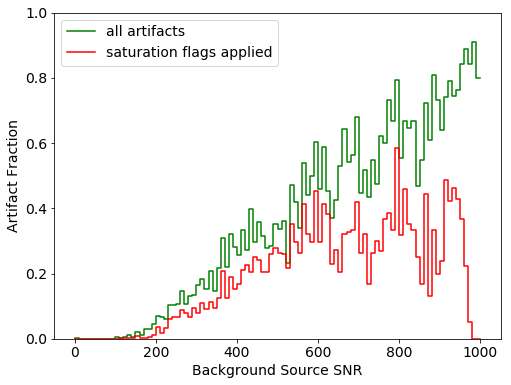

In [12]:
full_hosts = Table.read('./data/table/gal_4639/full_hosts.csv', format='ascii.csv')
base_applied = Table.read('./data/table/gal_4639/full_hosts_base_applied.csv', format='ascii.csv')
percent_list = []
for i in np.arange(-10, 1000, 10):
    low = i
    high = i + 10
    keep = np.logical_and(full_hosts['host_snr']>low, full_hosts['host_snr']<high)
    t_kept = full_hosts[keep]
    condition = np.logical_and(t_kept['is_artifact'] == 'True', t_kept['is_fake'] == 'False')
    percent = np.sum(condition) / len(t_kept)
    percent_list.append(percent)
percent_list_base_applied = []
for i in np.arange(-10, 1000, 10):
    low = i
    high = i + 10
    keep = np.logical_and(base_applied['host_snr']>low, base_applied['host_snr']<high)
    t_kept = base_applied[keep]
    condition = np.logical_and(t_kept['is_artifact'] == 'True', t_kept['is_fake'] == 'False')
    percent = np.sum(condition) / len(t_kept)
    percent_list_base_applied.append(percent)
plt.figure(figsize=(8, 6))
plt.step(np.arange(0, 1010, 10),  percent_list, color='g', label='all artifacts')
plt.step(np.arange(0, 1010, 10),  percent_list_base_applied, color='r', label='saturation flags applied')
plt.ylim(0, 1)
plt.ylabel('Artifact Fraction')
plt.xlabel('Background Source SNR')
plt.legend()
plt.savefig('./paper_plots/p_host_snr.pdf')

#### Saturation Artifacts

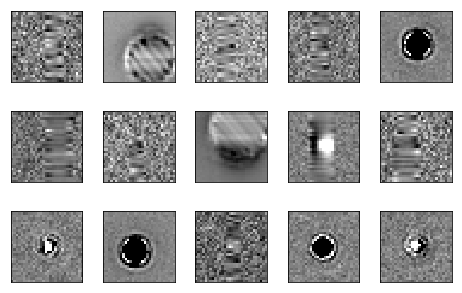

In [13]:
display_stamps(base_keep[15:], figsize=(8,5), hspace=0.4, wspace=0.2)
plt.savefig('./paper_plots/p_sat.pdf')

In [14]:
print('base_SdssShape_flag:    ', schema.extract('base_SdssShape_flag'), '\n')
print('base_GaussianFlux_flag_badShape:    ', schema.extract('base_GaussianFlux_flag_badShape'), '\n')
print()
print('slot_Shape_flag:    ', schema.extract('slot_Shape_flag'))

base_SdssShape_flag:     {'base_SdssShape_flag': SchemaItem(key=Key['Flag'](offset=32, bit=16), field=Field['Flag'](name="base_SdssShape_flag", doc="General Failure Flag"))} 

base_GaussianFlux_flag_badShape:     {'base_GaussianFlux_flag_badShape': SchemaItem(key=Key['Flag'](offset=32, bit=16), field=Field['Flag'](name="base_SdssShape_flag", doc="General Failure Flag"))} 


slot_Shape_flag:     {'slot_Shape_flag': SchemaItem(key=Key['Flag'](offset=32, bit=16), field=Field['Flag'](name="base_SdssShape_flag", doc="General Failure Flag"))}


In [15]:
sdss_count, all_count = 0, 0
for row in artifacts:
    if row['base_SdssShape_flag'] == 'True':
        sdss_count += 1
        if row['base_GaussianFlux_flag_badShape'] == 'True' and row['slot_Shape_flag'] == 'True':
            all_count += 1
print(sdss_count, all_count)

0 0


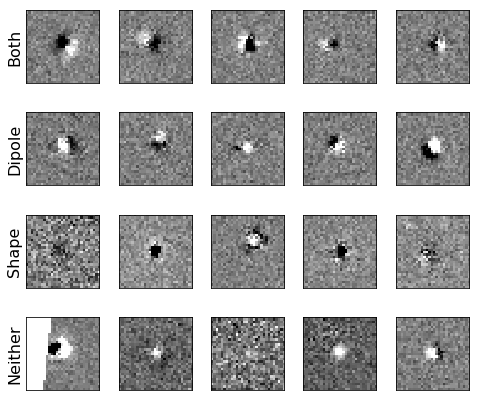

In [16]:
# broad
display_artifacts(broad, figsize=(8,7), hspace=0.4, wspace=0.2, dipole_flags=dipole_flags, sdss_flags=sdss_flags)
plt.savefig('./paper_plots/p_broad.pdf')

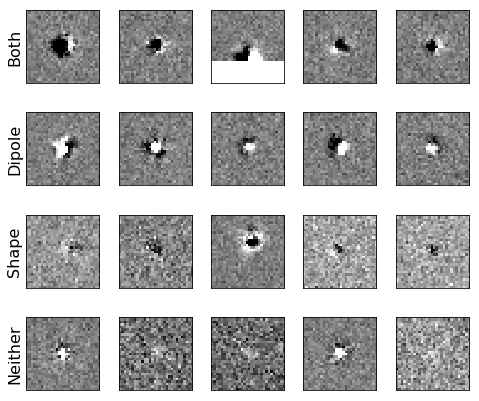

In [17]:
# near
display_artifacts(near, figsize=(8,7), hspace=0.4, wspace=0.2, dipole_flags=dipole_flags, sdss_flags=sdss_flags)
plt.savefig('./paper_plots/p_near.pdf')

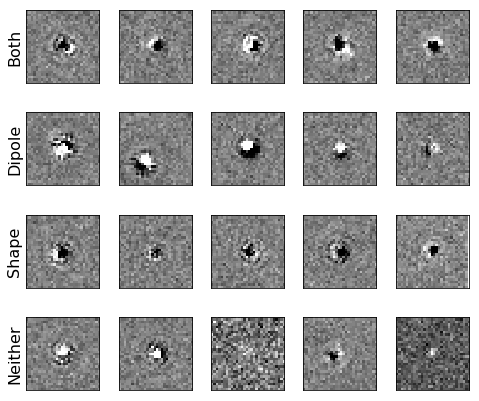

In [18]:
# sharp
display_artifacts(narrow, figsize=(8,7), hspace=0.4, wspace=0.2, dipole_flags=dipole_flags, sdss_flags=sdss_flags)
plt.savefig('./paper_plots/p_sharp.pdf')

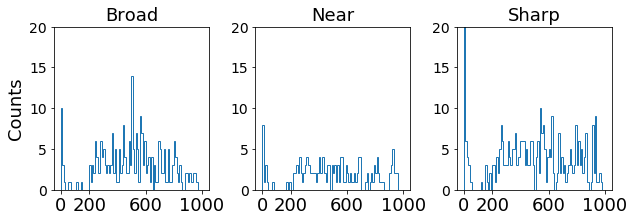

In [29]:

fig, ax = plt.subplots(1,3,figsize=(10, 3))
fig.subplots_adjust(wspace=0.3)
bins = np.arange(0, 1010, 10)
labelsize = 18
xticks = [0, 200, 600, 1000]
ylim = (0, 20)
ax[0].hist(broad['host_snr'], bins=bins, histtype='step')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, fontsize=labelsize)
ax[0].set_ylim(ylim)
ax[0].set_ylabel('Counts', size=labelsize)
# ax[0].set_xlabel('Source SNR', size=labelsize)
ax[0].set_title("Broad", size=labelsize)
ax[1].hist(near['host_snr'], bins=bins, histtype='step')
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, fontsize=labelsize)
ax[1].set_ylim(ylim)
# ax[1].set_xlabel('Source SNR', size=labelsize)
ax[1].set_title("Near", size=labelsize)
ax[2].hist(narrow['host_snr'], bins=bins, histtype='step')
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xticks, fontsize=labelsize)
ax[2].set_ylim(ylim)
# ax[2].set_xlabel('Source SNR', size=labelsize)
ax[2].set_title("Sharp", size=labelsize)
# plt.suptitle('Source SNR Distribution', size=labelsize, y=1.1)
plt.savefig('./paper_plots/p_fwhm_host_snr.pdf')

#### Faint Host

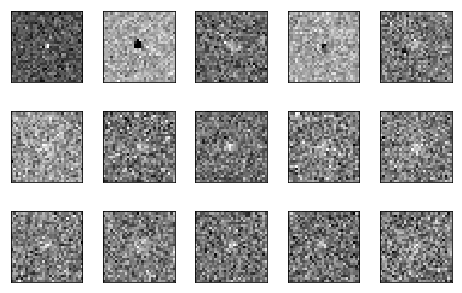

In [20]:
display_stamps(base_rm[np.logical_and(base_rm['host_snr'] < 50, base_rm['matched_status']=='True')][4:], figsize=(8,5), hspace=0.4, wspace=0.2)
plt.savefig('./paper_plots/p_faint_art.pdf')

#### unmatched

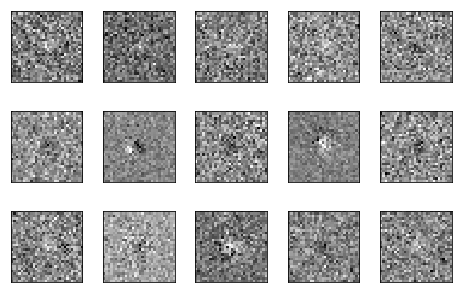

In [21]:
display_stamps(base_rm[base_rm['matched_status']=='False'][14:], figsize=(8,5), hspace=0.4, wspace=0.2)
plt.savefig('./paper_plots/p_unmatched.pdf')

In [16]:
al_diff = afwImage.ExposureF('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')
zogy_diff = afwImage.ExposureF('./data/patch_0to6/diff/zogy_55/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')

base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_suspectCenter',
             'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge','base_PixelFlags_flag_bad']
diff_diaSrc = BaseCatalog.readFits('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
diff_diaSrc_astropy = diff_diaSrc.asAstropy()
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
diaSrc_base_rm = dpu.remove_flag_astropy(diff_diaSrc_astropy, flag_list=base_flags)
diaSrc_dipole_keep = dpu.keep_flag_astropy(diaSrc_base_rm, flag_list=dipole_flags)

fig, ax = plt.subplots(2, 5, figsize=(10,5))
fig.subplots_adjust(hspace=0.05)
for i, row in enumerate(diaSrc_dipole_keep[1:]):
    if i ==5:
        break
    x = row['base_NaiveCentroid_x']
    y = row['base_NaiveCentroid_y']
    al_stamp = dpu.make_cutout(al_diff, x, y, cutout_size=30)
    zogy_stamp = dpu.make_cutout(zogy_diff, x, y, cutout_size=30)
    ax[0][i].imshow(interval(al_stamp.getImage().array), cmap='gray', origin='lower')
    ax[1][i].imshow(interval(zogy_stamp.getImage().array), cmap='gray', origin='lower')
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('AL', size=16)
        ax[1][i].set_ylabel('ZOGY', size=16)
plt.savefig('./paper_plots/p_al_zogy.pdf')


NameError: name 'afwImage' is not defined

#### explore base SdssShape flag

In [14]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
psf_table['psf_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
full_detections = Table.read('./data/table/gal_4639/full_detections.csv', format='ascii.csv')
for flag in (base_flags+dipole_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] /full_detections['base_PsfFlux_instFluxErr']
full_detections['psf_ratio'] = (full_detections['calexp_fwhm'] - full_detections['coadd_fwhm']) / full_detections['coadd_fwhm']

config = 'al_default'
db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)


# art_astropy are detected artifacts from fake injection pipeline
# full detections are diaSrc sources merged from diaSrc table after pipeline running
art_astropy = Table.from_pandas(art)
art_coord = SkyCoord(np.rad2deg(art_astropy['coord_ra'].data),
                     np.rad2deg(art_astropy['coord_dec'].data),
                     frame="icrs", unit="deg")
det_coord = SkyCoord(np.rad2deg(full_detections['coord_ra'].data),
                     np.rad2deg(full_detections['coord_dec'].data),
                     frame="icrs", unit="deg")
matched_status, matched_idx = dpu.two_direction_skymatch(art_coord,  det_coord, radius=2 * u.arcsec)

base_keep = dpu.keep_flag_astropy(artifacts, flag_list=base_flags)
base_rm = dpu.remove_flag_astropy(artifacts, flag_list=base_flags)
dipole_keep = dpu.keep_flag_astropy(base_rm, flag_list=dipole_flags)
dipole_rm = dpu.remove_flag_astropy(base_rm, flag_list=dipole_flags)
print(f"base flag set: {len(base_keep)}, both base and sdss: {np.sum(base_keep['base_SdssShape_flag']=='True')}")

print(f"dipole flag set: {len(dipole_keep)}, both dipole and sdss: {np.sum(dipole_keep['base_SdssShape_flag']=='True')}")

print(f"dipole flag not set: {len(dipole_rm)}, no dipole but sdss: {np.sum(dipole_rm['base_SdssShape_flag']=='True')}")

base flag set: 1090, both base and sdss: 855
dipole flag set: 302, both dipole and sdss: 252
dipole flag not set: 470, no dipole but sdss: 324


In [111]:
# if (IxxIyy < (1.0 + epsilon) * Ixy_sq)
# base_SdssShape_xx
# base_SdssShape_psf_xx
# base_SdssShape_instFlux_xx_Cov

In line 783 of [https://github.com/lsst/meas_base/blob/26961ef6c7a3bd91c4b40a0307c740244fea775e/src/SdssShape.cc#L783], we have (Ixx * Iyy < (1.0 + epsilon) * Ixy_sq). Note that IxxIyy - Ixy * Ixy is the determinant of the covariance matrix of image moments, which should be equal or biggher than 0 if all pixel values are positive. There are two conditions that (IxxIyy < (1.0 + epsilon) * Ixy_sq:

1. Small variance. The deternimant is invariant under othogonal transformation. In the eigenspace of the covariance matrix, eignevalues represent pixel variances. The determinant is the multiplication of all eigenvalues. IxxIyy < (1.0 + epsilon) * Ixy_sq implied a small deternimant, which means photons are distributed near 0. (unlikely to happen.)

2. Negative pixel value. If we have negative pixel values (negative probability), the covarice matrix of image of moments can have negative determinant. This may happen for artifacts.

In [112]:
epsilon = 1.0e-6
count = 0
both = 0
for row in artifacts:
    xx = row['base_SdssShape_xx']
    yy = row['base_SdssShape_yy']
    xy = row['base_SdssShape_xy']
    if xx * yy < (1.0 + epsilon) * xy * xy:
        count += 1
        if row['base_SdssShape_flag'] == 'True':
            both += 1

In [113]:
len(artifacts), np.sum(artifacts['base_SdssShape_flag'] == 'True')

(1862, 1431)

In [114]:
print(f'Only {count} artifacts have negative determinants, {both} of them have sdss flag set.')

Only 27 artifacts have negative determinants, 27 of them have sdss flag set.


Text(0.5, 0.98, 'base_SdssShape')

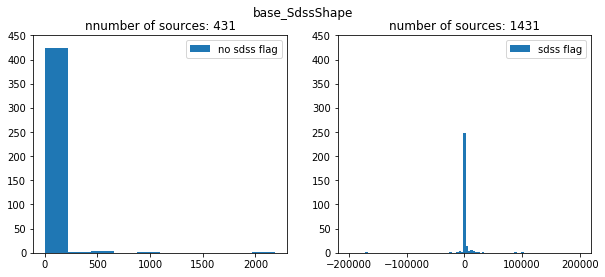

In [182]:
shape = 'base_SdssShape'
no_sdss, sdss = [], []
for row in artifacts:
    xx = row[f'{shape}_xx']
    yy = row[f'{shape}_yy']
    xy = row[f'{shape}_xy']
    det = xx * yy - (1.0 + epsilon) * xy * xy
    if row['base_SdssShape_flag'] == 'True':
        sdss.append(det)
    else:
        no_sdss.append(det)
        
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(no_sdss, label='no sdss flag')
# ax[0].set_xlim(-50, 2000)
ax[0].set_ylim(0, 450)
ax[0].legend()
ax[1].hist(sdss, bins=np.linspace(-200000, 200000, 100), label='sdss flag')
# ax[1].set_xlim(-500, 2000)
ax[1].set_ylim(0, 450)
ax[1].legend()
ax[0].set_title(f'nnumber of sources: {len(no_sdss)}')
ax[1].set_title(f'number of sources: {len(sdss)}')
plt.suptitle(shape)

431 1431


Text(0.5, 0.98, 'base_SdssShape_psf')

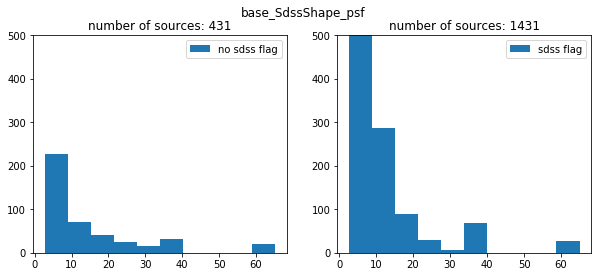

In [116]:
import matplotlib.pyplot as plt

shape = 'base_SdssShape_psf'
no_sdss, sdss = [], []
for row in artifacts:
    xx = row[f'{shape}_xx']
    yy = row[f'{shape}_yy']
    xy = row[f'{shape}_xy']
    det = xx * yy - (1.0 + epsilon) * xy * xy
    if row['base_SdssShape_flag'] == 'True':
        sdss.append(det)
    else:
        no_sdss.append(det)
print(len(no_sdss), len(sdss))
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(no_sdss, label='no sdss flag')
# ax[0].set_xlim(-50, 2000)
ax[0].set_ylim(0, 500)
ax[0].legend()
ax[1].hist(sdss, label='sdss flag')
# ax[1].set_xlim(-500, 2000)
ax[1].set_ylim(0, 500)
ax[1].legend()
ax[0].set_title(f'number of sources: {len(no_sdss)}')
ax[1].set_title(f'number of sources: {len(sdss)}')
plt.suptitle(shape)

431 1431


Text(0.5, 0.98, 'base_SdssShape_instFlux')

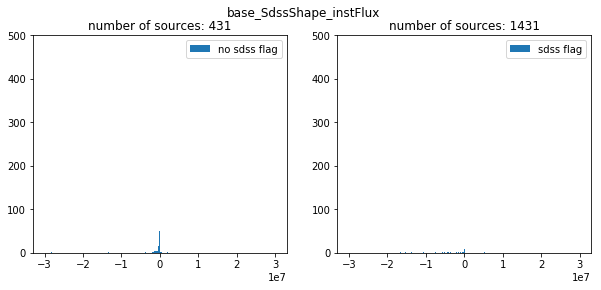

In [184]:
import matplotlib.pyplot as plt

shape = 'base_SdssShape_instFlux'
no_sdss, sdss = [], []
for row in artifacts:
    xx = row[f'base_SdssShape_instFlux_xx_Cov']
    yy = row[f'base_SdssShape_instFlux_yy_Cov']
    xy = row[f'base_SdssShape_instFlux_xy_Cov']
    det = xx * yy - (1.0 + epsilon) * xy * xy
    if row['base_SdssShape_flag'] == 'True':
        sdss.append(det)
    else:
        no_sdss.append(det)
print(len(no_sdss), len(sdss))
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(no_sdss, bins=np.linspace(-3*1e7, 3*1e7, 400), label='no sdss flag')
# ax[0].set_xlim(-50, 2000)
ax[0].set_ylim(0, 500)
ax[0].legend()
ax[1].hist(sdss, bins=np.linspace(-3*1e7, 3*1e7, 400), label='sdss flag')
# ax[1].set_xlim(-500, 2000)
ax[1].set_ylim(0, 500)
ax[1].legend()
ax[0].set_title(f'number of sources: {len(no_sdss)}')
ax[1].set_title(f'number of sources: {len(sdss)}')
plt.suptitle(shape)

In [118]:
"""
for c in artifacts.columns:
    print(c)
""";

#### sdss flag morphology

In [2]:
from astropy.visualization import ZScaleInterval
import lsst.afw.image as afwImage
import lsst.geom as geom
import matplotlib.pyplot as plt
interval = ZScaleInterval()

In [3]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')
psf_table['psf_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
full_detections = Table.read('./data/table/gal_4639/full_detections.csv', format='ascii.csv')
for flag in (base_flags+dipole_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] /full_detections['base_PsfFlux_instFluxErr']
full_detections['psf_ratio'] = (full_detections['calexp_fwhm'] - full_detections['coadd_fwhm']) / full_detections['coadd_fwhm']

config = 'al_default'
db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)


# art_astropy are detected artifacts from fake injection pipeline
# full detections are diaSrc sources merged from diaSrc table after pipeline running
art_astropy = Table.from_pandas(art)
art_coord = SkyCoord(np.rad2deg(art_astropy['coord_ra'].data),
                     np.rad2deg(art_astropy['coord_dec'].data),
                     frame="icrs", unit="deg")
det_coord = SkyCoord(np.rad2deg(full_detections['coord_ra'].data),
                     np.rad2deg(full_detections['coord_dec'].data),
                     frame="icrs", unit="deg")
matched_status, matched_idx = dpu.two_direction_skymatch(art_coord,  det_coord, radius=2 * u.arcsec)

# artifacts from full detections
artifacts = full_detections[matched_idx]
base_rm = dpu.remove_flag_astropy(artifacts, flag_list=base_flags)
# fwhm class
broad = base_rm[base_rm['psf_ratio']>=0]
near = base_rm[np.logical_and(base_rm['psf_ratio']<0, base_rm['psf_ratio']>=-0.05)]
narrow = base_rm[base_rm['psf_ratio']<-0.05]
print(f"total art: {len(artifacts)}, remove base: {len(base_rm)}, broad: {len(broad)}, near: {len(near)}, sharp: {len(narrow)}")

total art: 1862, remove base: 772, broad: 261, near: 164, sharp: 347


In [4]:
psf_table['fwhm_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
broad_id, near_id, sharp_id = [], [], []
for i, r in enumerate(psf_table['fwhm_ratio']):
    if r >= 0:
        broad_id.append(i)
    elif r < 0 and r >= -0.05:
        near_id.append(i)
    else:
        sharp_id.append(i)
print('broad id: ', broad_id)
print('near id: ', near_id)
print('sharp id: ', sharp_id)

broad id:  [1, 2, 5, 12, 13, 16, 21, 24, 26, 32, 33, 35, 36, 37, 38, 39, 40, 43, 49, 53, 57, 58, 59, 60, 62, 63, 64, 65, 66, 69]
near id:  [0, 3, 6, 9, 14, 15, 22, 25, 29, 30, 41, 44, 46, 50, 51, 55]
sharp id:  [4, 7, 8, 10, 11, 17, 18, 19, 20, 23, 27, 28, 31, 34, 42, 45, 47, 48, 52, 54, 56, 61, 67, 68]


In [5]:
base_keep = dpu.keep_flag_astropy(artifacts, flag_list=base_flags)
base_rm = dpu.remove_flag_astropy(artifacts, flag_list=base_flags)
dipole_keep = dpu.keep_flag_astropy(base_rm, flag_list=dipole_flags)
dipole_rm = dpu.remove_flag_astropy(base_rm, flag_list=dipole_flags)

#### define artifact morphology

In [6]:
al_norm = afwImage.ExposureF(psf_table[1]['diffexp_path'])
al_norm_src = BaseCatalog.readFits(psf_table[1]['diaSrc_path'])
al_norm_src = al_norm_src.asAstropy()
al_norm_saturation = dpu.keep_flag_astropy(al_norm_src, flag_list=base_flags)
al_norm_nonsat = dpu.remove_flag_astropy(al_norm_src, flag_list=base_flags)
al_norm_dipole = dpu.keep_flag_astropy(al_norm_nonsat, flag_list=dipole_flags)
al_norm_remaining = dpu.remove_flag_astropy(al_norm_nonsat, flag_list=dipole_flags)

In [7]:
al_deconv = afwImage.ExposureF(psf_table[4]['diffexp_path'])
al_deconv_src = BaseCatalog.readFits(psf_table[4]['diaSrc_path'])
al_deconv_src = al_deconv_src.asAstropy()
al_deconv_src = dpu.remove_flag_astropy(al_deconv_src, flag_list=base_flags)

In [8]:
def diaplay_single_stamp(exp, table, row_id, cutout_size = 50, ax=None, title=None):
    row = table[row_id]
    x, y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
    cutout_exp = dpu.make_cutout(exp, x, y, cutout_size=cutout_size)
    xy = geom.PointI(x, y)
    if not ax:
        plt.imshow(interval(cutout_exp.getImage().array), cmap='gray', origin='lower')
    else:
        ax.imshow(interval(cutout_exp.getImage().array), cmap='gray', origin='lower')
        ax.set_title(title, size=16)
        ax.set_xticks([])
        ax.set_yticks([])

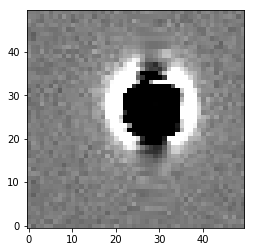

In [179]:
row_id = 1
diaplay_single_stamp(al_norm, al_norm_saturation, row_id)
# saturation

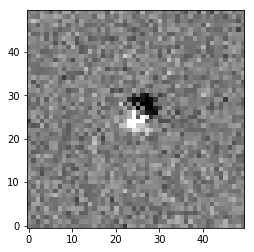

In [129]:
row_id = 1
diaplay_single_stamp(al_norm, al_norm_dipole, row_id)
# dipole 1

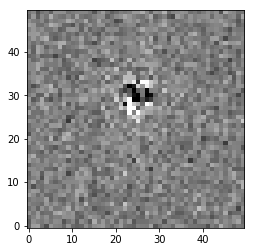

In [159]:
row_id = 21
diaplay_single_stamp(al_norm, al_norm_remaining, row_id)
# correlated pixels, 7, 21

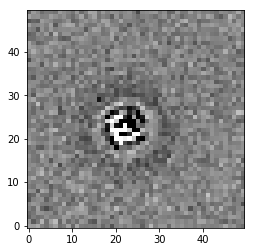

In [214]:
row_id = 6
diaplay_single_stamp(al_deconv, al_deconv_src, row_id)
# deconvolution 6

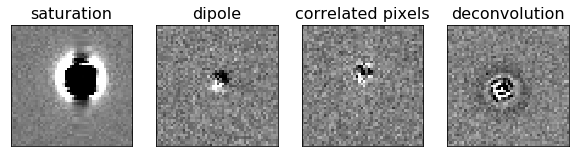

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(10,4))
diaplay_single_stamp(al_norm, al_norm_saturation, row_id=1, ax=ax[0], title='saturation')
diaplay_single_stamp(al_norm, al_norm_dipole, row_id=1, ax=ax[1], title='dipole')
diaplay_single_stamp(al_norm, al_norm_remaining, row_id=21, ax=ax[2], title='correlated pixels')
diaplay_single_stamp(al_deconv, al_deconv_src, row_id=6, ax=ax[3], title='deconvolution')
plt.savefig('art_definition.pdf')

In [124]:
def display_artifacts(art_table, figsize=(10,15), hspace=0.5, dipole_flags=dipole_flags):
    dipole_keep = dpu.keep_flag_astropy(art_table, flag_list=dipole_flags)
    dipole_rm = dpu.remove_flag_astropy(art_table, flag_list=dipole_flags)

    fig, ax = plt.subplots(3, 5, figsize=figsize)
    fig.subplots_adjust(hspace=hspace)

    table_ls = [dipole_keep, dipole_keep, dipole_rm]
    sdss_ls = ['True', 'False', 'True']
    ylabel_ls = ['both', 'dipole', 'sdss']
    
    for r in range(3):
        t = table_ls[r]
        sdss = sdss_ls[r]
        ylabel = ylabel_ls[r]
        c = 0
        for i, diaSrc in enumerate(t):
            if c == 5:
                break
            flag = diaSrc['base_SdssShape_flag']
            if flag == sdss:
                # print(diaSrc[dipole_flags], flag)
                diff_exp = afwImage.ExposureF(diaSrc['diffexp_path'])
                x = diaSrc['base_NaiveCentroid_x']
                y = diaSrc['base_NaiveCentroid_y']
                diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
                ax[r][c].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
                ax[r][c].set_xticks([])
                ax[r][c].set_xticks([])
                ax[r][c].set_yticks([])
                ax[r][c].set_yticks([])
                if c == 0:
                    ax[r][c].set_ylabel(ylabel, size=16)       
                c += 1
        # print('\n')
    # print('\n')

ip_diffim_DipoleFit_flag_classification ip_diffim_DipoleFit_flag_classificationAttempted
--------------------------------------- ------------------------------------------------
                                   True                                             True True
ip_diffim_DipoleFit_flag_classification ip_diffim_DipoleFit_flag_classificationAttempted
--------------------------------------- ------------------------------------------------
                                   True                                             True True
ip_diffim_DipoleFit_flag_classification ip_diffim_DipoleFit_flag_classificationAttempted
--------------------------------------- ------------------------------------------------
                                   True                                             True True
ip_diffim_DipoleFit_flag_classification ip_diffim_DipoleFit_flag_classificationAttempted
--------------------------------------- ------------------------------------------------
      

Text(0.5, 0.98, 'broad')

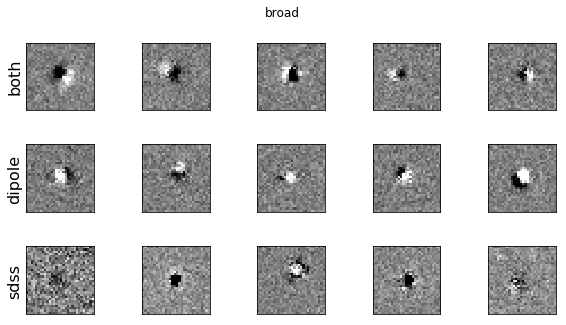

In [207]:
# tests
display_artifacts(broad, figsize=(10,5), hspace=0.5)
plt.suptitle('broad')

Text(0.5, 0.98, 'broad')

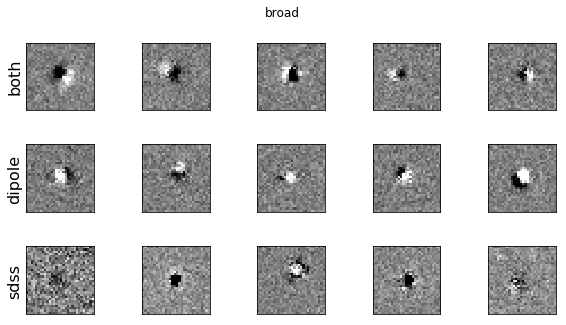

In [209]:
# broad
display_artifacts(broad, figsize=(10,5), hspace=0.5)
plt.suptitle('broad')

Text(0.5, 0.98, 'near')

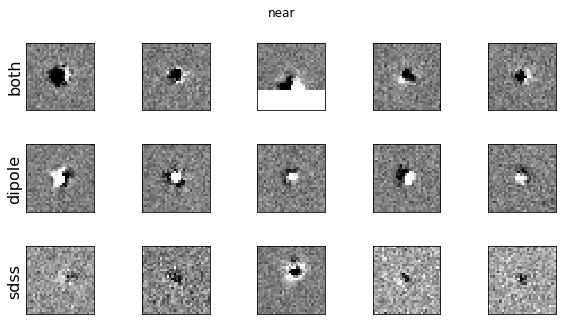

In [200]:
# near
display_artifacts(near, figsize=(10,5), hspace=0.5)
plt.suptitle('near')

Text(0.5, 0.98, 'sharp')

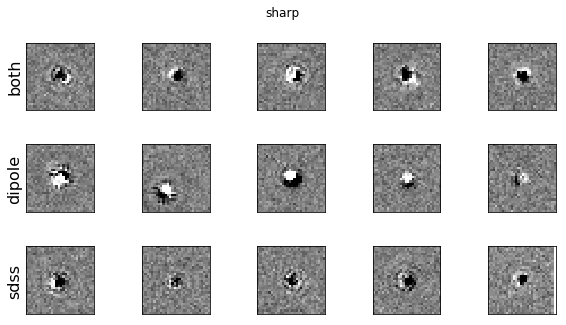

In [202]:
# sharp
display_artifacts(narrow, figsize=(10,5), hspace=0.5)
plt.suptitle('sharp')

define shape artifacts?
purity is useleff


#### data info

We want to get MJD, filter, magToInstFlux translation, background level, gain, zeropoint information of a calexp.

In [167]:
import lsst
from scipy.stats import sigmaclip
import numpy as np

In [126]:
from lsst.daf.persistence import Butler
calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)
# get exp and photocalib
calexp_id = {'visit': 1013665, 'detector': 79, 'filter': 'i'}
calexp_exp = calexp_butler.get('calexp', calexp_id)
calexp_photocalib = calexp_butler.get('calexp_photoCalib', calexp_id)
# get the source table measured from the calexp exposure
calexp_src = calexp_butler.get('src', calexp_id)

In [170]:
# mjd
# https://community.lsst.org/t/how-should-one-efficiently-get-the-mjd-for-a-source-catalog/3733/2
info = calexp_exp.getInfo()
# ap_corr = info.getApCorrMap()
mjd = info.getVisitInfo().getDate().get(lsst.daf.base.DateTime.MJD)
# lsst.daf.base.DateTime.UTC
print(f'MJD: {mjd}')

MJD: 61076.1177582199


In [152]:
# filter
print('filter')
filt = calexp_exp.getFilter()
filt.getId(), filt.getName(), filt.getNames()

filter


(6, 'i', ['275CutOn', '550CutOn', 'NONE', 'g', 'i', 'r', 'u', 'y', 'z'])

In [154]:
# detector
print('detector')
det = calexp_exp.getDetector()
det.getName(), det.getId(), det.getId(), det.getType(), det.getSerial()

detector


('R20_S21', 79, 79, DetectorType.SCIENCE, 'ITL-3800C-146-Dev')

In [151]:
# sky background estimated using image plane
img = calexp_exp.getImage().array
img = img[~np.isnan(img)]
clipped, _, _ = sigmaclip(img, low=5, high=5)
var_of_img = np.var(clipped)
print(f'variance of image: {var_of_img}')

variance of image: 6277.701171875


In [147]:
# mean variance plane
var = calexp_exp.getVariance().array
var = var[~np.isnan(var)]
clipped, _, _ = sigmaclip(var, low=5, high=5)
mean_of_var = np.mean(clipped)
print(f'mean of variance plane: {mean_of_var}')

mean of variance plane: 6046.86328125


In [176]:
inst_to_nJ = photo_calib.instFluxToNanojansky(1)
print(f'instFlux to nanoJansky: {inst_to_nJ}')
print('Is this equivalent to gain?')

instFlux to nanoJansky: 0.6724090041131134
Is this equivalent to gain?


In [146]:
# mag zp
photo_calib = calexp_exp.getPhotoCalib()
mag_zp = photo_calib.getInstFluxAtZeroMagnitude()
print(f'mag zp: {mag_zp}')

mag zp: 5399660809851.72


In [178]:
mag_zp_ls = []
sky_ls = []
for row in psf_table:
    calexp_path = row['calexp_path']
    calexp_exp = afwImage.ExposureF(calexp_path)
    mag_zp = calexp_exp.getPhotoCalib().getInstFluxAtZeroMagnitude()
    mag_zp_ls.append(mag_zp)
    
    img = calexp_exp.getImage().array
    img = img[~np.isnan(img)]
    clipped, _, _ = sigmaclip(img, low=5, high=5)
    var_of_img = np.var(clipped)
    sky_ls.append(np.sqrt(var_of_img))

Text(0.5, 1.0, 'standard deviation of image plane')

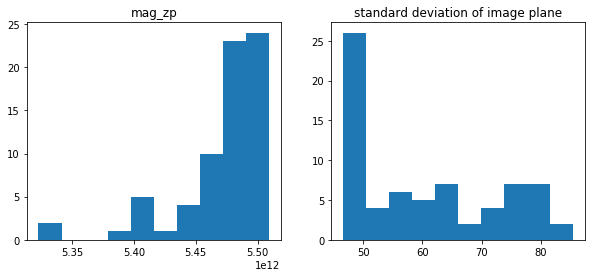

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(mag_zp_ls)
ax[0].set_title('mag_zp')
ax[1].hist(sky_ls)
ax[1].set_title('standard deviation of image plane')

#### pixel offset

In [6]:
def get_gaussian_pdf(fwhm):
    sigma = fwhm / np.sqrt(8 * np.log(2))
    half_size = 20
    
    x = np.arange(-half_size, half_size+1, 0.1)
    y = np.arange(-half_size, half_size+1, 0.1)
    xx, yy = np.meshgrid(x, y)
    grid = np.dstack((xx, yy))
    rv = multivariate_normal(mean=[0,0], cov=[sigma, sigma])
    distribution = rv.pdf(grid)
    return distribution

def estimate_one_percent_distance(fwhm, threshold=0.1):
    pdf = get_gaussian_pdf(fwhm)
    pad_size = pdf.shape[1] // 2
    pdf = np.pad(pdf, pad_width=((0, 0),(0, pad_size)), mode='constant', constant_values=0)
    
    for i in range (1, pad_size):
        pdf_rolled = np.roll(pdf, shift=i, axis=1)
        res = np.sum(np.abs(pdf - pdf_rolled)) / 2
        if res > threshold:
            return i, res
    return None, None

In [20]:
psf_table = pd.read_csv('./data/table/gal_4639/psf_fwhm.csv')
min_shift = np.floor(psf_table['calexp_fwhm'].min())
max_shift = np.ceil(psf_table['calexp_fwhm'].max())
fwhm_list = np.arange(int(min_shift), int(max_shift+1))

shift_list, res_list = [], []
for fwhm in fwhm_list:
    shift, res = estimate_one_percent_distance(fwhm, threshold=0.1)
    shift_list.append(shift)
    res_list.append(res)

Text(0, 0.5, 'residual at the first pixel shift')

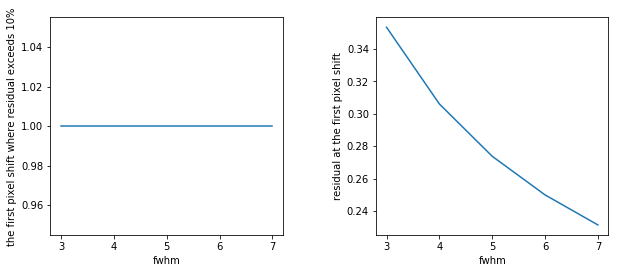

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.subplots_adjust(wspace=0.4)
ax[0].plot(fwhm_list, shift_list)
ax[0].set_xlabel('fwhm')
ax[0].set_ylabel('the first pixel shift where residual exceeds 10%')
ax[1].plot(fwhm_list, res_list)
ax[1].set_xlabel('fwhm')
ax[1].set_ylabel('residual at the first pixel shift')

In [10]:
calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)

In [22]:
row = psf_table.loc[0]

In [49]:
dipole_src = pd.DataFrame()
for idx, row in psf_table.iterrows():
    diaSrc_path = row['diaSrc_path']
    diffexp_path = row['diffexp_path']
    # src
    calexp_id = {'visit': int(row['visit']), 'detector': int(row['detector']), 'filter': str(row['filter'])}
    src = calexp_butler.get('src', calexp_id)
    src_astropy = src.asAstropy()
    # diaSrc
    diaSrc_path = row['diaSrc_path']
    diaSrc = BaseCatalog.readFits(diaSrc_path)
    diaSrc_astropy = diaSrc.asAstropy()
    # dipole table
    base_rm = dpu.remove_flag_astropy(diaSrc_astropy, flag_list=base_flags)
    dipole_keep = dpu.keep_flag_astropy(base_rm, flag_list=dipole_flags)
    # coord matching
    dipole_coord = SkyCoord(np.rad2deg(dipole_keep['coord_ra'].data),
                            np.rad2deg(dipole_keep['coord_dec'].data),
                            frame="icrs", unit="deg")
    src_coord = SkyCoord(np.rad2deg(src_astropy['coord_ra'].data),
                         np.rad2deg(src_astropy['coord_dec'].data),
                         frame="icrs", unit="deg")
    if len(src_coord)==0 or len(dipole_coord)==0:
        continue
    matched_status, matched_idx = dpu.two_direction_skymatch(dipole_coord,  src_coord, radius=2 * u.arcsec)
    # joint table
    dipole_df = dipole_keep.to_pandas()
    src_df = src_astropy.to_pandas()
    src_matched = src_df.loc[matched_idx].reset_index()
    joint_table = dipole_df.join(src_matched, lsuffix='_diaSrc', rsuffix='_src')
    joint_table['matched_status'] = matched_status
    joint_table = joint_table.loc[joint_table['matched_status'] == True].reset_index()  
    dipole_src = pd.concat([dipole_src, joint_table], axis=0, ignore_index=True)

In [50]:
dipole_src.to_csv('dipole_src_matching.csv', index=False)

In [51]:
dipole_src_df = pd.read_csv('dipole_src_matching.csv')

In [61]:
dipole_frac = (np.abs(dipole_src_df['ip_diffim_NaiveDipoleFlux_pos_instFlux']) + np.abs(dipole_src_df['ip_diffim_NaiveDipoleFlux_neg_instFlux'])) / 2 \
            / np.abs(dipole_src_df['base_PsfFlux_instFlux_src'])

Text(0, 0.5, 'Count')

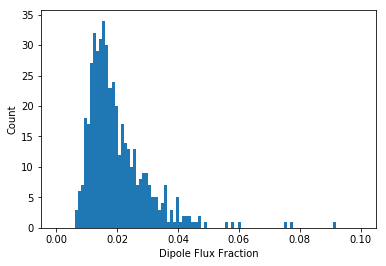

In [67]:
plt.hist(dipole_frac, bins = np.linspace(0, 0.1, 100));
plt.xlabel('Dipole Flux Fraction')
plt.ylabel('Count')

In [7]:
flag_df = pd.read_csv('./data/table/gal_4639/flag_metric.csv')
flag_df.sort_values(by=['recall', 'precision', 'f1'], ascending=False)

,flag,description,precision,recall,f1
26,base_SdssShape_flag,General Failure Flag,0.733127,1.000000,0.846016
27,base_GaussianFlux_flag_badShape,General Failure Flag,0.733127,1.000000,0.846016
28,slot_Shape_flag,General Failure Flag,0.733127,1.000000,0.846016
6,base_SdssCentroid_flag,General Failure Flag,0.671964,1.000000,0.803802
29,base_SdssShape_flag_unweightedBad,Both weighted and unweighted moments were invalid,0.650907,1.000000,0.788545
30,base_GaussianFlux_flag_badShape_unweightedBad,Both weighted and unweighted moments were invalid,0.650907,1.000000,0.788545
31,slot_Shape_flag_unweightedBad,Both weighted and unweighted moments were invalid,0.650907,1.000000,0.788545
70,base_GaussianFlux_flag,General Failure Flag,0.630122,1.000000,0.773098
10,base_SdssCentroid_flag_notAtMaximum,Object is not at a maximum,0.618277,1.000000,0.764117
83,base_PixelFlags_flag_saturatedCenter,Saturated pixel in the Source center,0.598584,1.000000,0.748893


In [8]:
t = BaseCatalog.readFits('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/schema/deepDiff_diaSrc.fits')
schema = t.schema

In [9]:
schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=32, bit=0)),
    (Field['D'](name="base_NaiveCentroid_x", doc="centroid from Naive Centroid algorithm", units="pixel"), Key<D>(offset=40, nElements=1)),
    (Field['D'](name="base_NaiveCentroid_y", doc="centroid from Naive Centroid algorithm", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['Flag'](name="base_NaiveCentroid_flag", doc="General Failure Flag"), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="base_NaiveCentroid_flag_noCounts", doc="Object to be centroide

`'base_GaussianFlux_flag_badShape'->'base_SdssShape_flag'`

`'slot_Shape'->'base_SdssShape'`

` (Field['Flag'](name="base_SdssShape_flag", doc="General Failure Flag"), Key['Flag'](offset=32, bit=16))`